In [1]:
import pandas as pd
import os 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib  import pyplot as plt
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
import random
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import recall_score
df = pd.read_csv('data.csv')
df.columns = [i.lower() for i in df.columns]
pd.options.display.width=None

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
df.columns = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0','pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'target']

<AxesSubplot:>

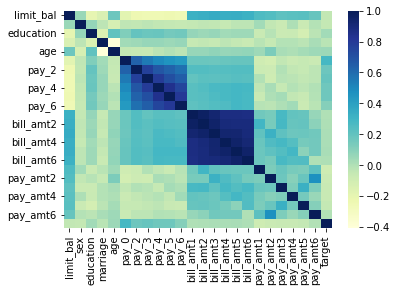

In [4]:
import seaborn as sns
corr  = df.corr()
sns.heatmap(corr,cmap="YlGnBu")

In [5]:
data = df
        
selected_features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
target = 'target'
X = data[selected_features]
y = data[target]

In [6]:
y.value_counts()

0    787
1    214
Name: target, dtype: int64

1    787
0    787
Name: target, dtype: int64


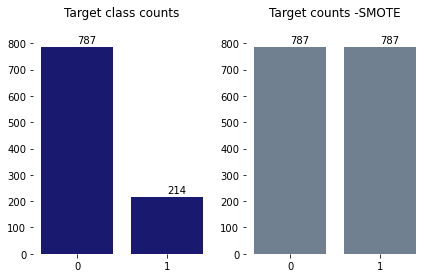

In [7]:
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.title('Target class counts',pad = 20)
classes = y.value_counts().index
counts = y.value_counts()
plt.bar(x =classes,height = counts,color = 'midnightblue')
plt.annotate('787',(0,800))
plt.annotate('214',(1,230))

plt.xticks(classes)
plt.box(False)


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(y.value_counts())
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.2)

# print('X_train shape :',X_train.shape)
# print('y_train shape :',y_train.shape)
# print('X_test shape :',X_test.shape)
# print('y_test shape :',y_test.shape)
# 
plt.subplot(1, 2, 2)
plt.title('Target counts -SMOTE',pad = 20)
classes = y.value_counts().index
counts = y.value_counts()
plt.bar(x =classes,height = counts,color = 'slategrey')
plt.xticks(classes)
plt.annotate('787',(0,800))
plt.annotate('787',(1,800))

plt.box(False)

plt.show()

In [8]:
len(X_train.columns)

23

In [9]:
# scaling X_train using robustscaler 
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test),columns = X_test.columns)

In [10]:
# gassian mixture model
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, random_state=0).fit(X_train)
gm_labels = gm.predict(X_train)

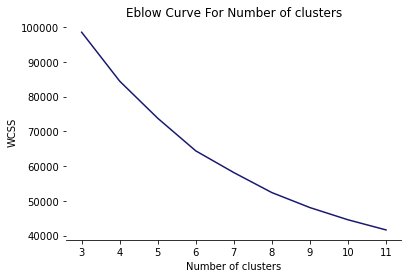

In [11]:
# K Means features 
from sklearn.cluster import KMeans
wcss = [] 
for i in range(3, 12): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train) 
    wcss.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.title('Eblow Curve For Number of clusters')
plt.plot(range(3,12), wcss,color = 'midnightblue')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [12]:
k = 6
kmeans = KMeans(n_clusters = k)
kmeans_clusters = kmeans.fit_predict(X_train)

In [13]:
## Adding Unsupervised feature labels 
X_train['kmeans_labels'] = kmeans_clusters 
X_train['gm_labels'] = gm_labels 

In [59]:
# creating an aggregated value for bill_amt and pay_amt for training and testing features 
def aggregate_cols(cols,df):
    aggregated = []
    for i in range(len(df[cols])):
        agg_sum = df[cols].iloc[i].sum()
        aggregated.append(agg_sum)
    return aggregated 
                   
def standardize(col,col2 = None):
    if col2:
        mean = np.mean(col2)
        std = np.std(col2)
        col = [(i-mean)/std for i in col]
    else:
        mean = np.mean(col)
        std = np.std(col)
        col = [(i-mean)/std for i in col]
    
    return col
bill_cols = [i for i in df.columns if i.startswith('bill_amt')]
bill_aggregated = standardize(aggregate_cols(bill_cols,X_train))
    
pay_cols = [i for i in df.columns if i.startswith('pay_amt')]
pay_aggregated = standardize(aggregate_cols(pay_cols,X_train))

In [60]:
X_train['pay_aggregated'] = pay_aggregated 
X_train['bill_aggregated'] = bill_aggregated

In [61]:
X_train

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,-0.611111,0.0,0.0,0.0,-0.153846,2.0,1.0,0.0,0.0,0.0,...,-0.541803,-0.106092,-0.211716,-0.226477,-0.179029,-0.138968,0,2,-0.447833,-0.409272
1,0.722222,0.0,-1.0,1.0,0.769231,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.460109,-0.380646,-0.235697,-0.254950,-0.233311,-0.231719,0,0,-0.475111,-0.629581
2,2.055556,1.0,-1.0,0.0,0.000000,-2.0,-2.0,-2.0,-1.0,-1.0,...,-0.508743,0.256872,0.084618,0.036328,-0.002360,4.674897,0,4,-0.034450,-0.618316
3,-0.444444,0.0,1.0,0.0,1.769231,3.0,2.0,0.0,0.0,0.0,...,-0.546448,0.032149,-0.172662,-0.194731,-0.188132,-0.141817,0,0,-0.434453,-0.436590
4,-0.611111,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,...,-0.106831,0.482238,-0.116821,-0.137130,-0.109238,-0.084204,0,0,-0.355217,-0.365292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.444444,1.0,0.0,0.0,1.153846,0.0,0.0,0.0,0.0,0.0,...,-0.105738,0.160746,0.169921,0.296187,0.164194,0.005065,0,2,-0.302212,-0.156413
1255,-0.555556,1.0,0.0,1.0,-0.538462,-1.0,-1.0,2.0,0.0,-1.0,...,0.310383,-0.482238,-0.343953,9.364752,-0.390425,0.167142,0,4,0.249499,-0.221596
1256,-0.328533,0.0,0.0,1.0,-0.384615,0.0,1.0,1.0,0.0,0.0,...,0.327869,-0.398971,0.655019,0.594993,0.123736,-0.282684,0,4,-0.279298,0.203874
1257,-0.277778,0.0,-1.0,1.0,0.076923,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.541803,1.720945,0.244947,0.092620,6.333109,0.433682,0,4,0.301049,-0.531751


In [62]:
# preprocessing X_test
test_kmeans_labels = kmeans.predict(X_test)
test_gm_labels = gm.predict(X_test)
X_test['kmeans_labels'] = test_kmeans_labels
X_test['gm_labels'] = test_gm_labels

# while transforming X_test we wont fit ( using the existting mean and std) 
bill_aggregated = standardize(aggregate_cols(bill_cols,X_test),aggregate_cols(bill_cols,X_train))
pay_aggregated = standardize(aggregate_cols(pay_cols,X_test),aggregate_cols(bill_cols,X_train))

X_test['pay_aggregated'] = pay_aggregated 
X_test['bill_aggregated'] = bill_aggregated

In [63]:
X_test

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,0.277778,0.0,0.0,0.0,-0.538462,0.0,0.0,0.0,0.0,0.0,...,-0.175410,0.637197,-0.173347,-0.217640,-0.243088,-0.222222,0,2,-0.427636,-0.515911
1,-0.444444,0.0,-1.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,...,-0.238525,-0.136955,-0.270298,-0.276878,1.087323,-0.277303,0,2,-0.394665,-0.452203
2,-0.277778,1.0,1.0,1.0,0.076923,0.0,-1.0,0.0,0.0,0.0,...,2.868852,1.607459,0.683796,0.296187,0.621038,0.301361,0,4,0.364623,-0.322068
3,0.691000,0.0,-1.0,1.0,0.307692,0.0,-1.0,-1.0,0.0,-1.0,...,-0.546448,1.025880,-0.343953,3.874980,0.057991,0.222539,0,4,0.120425,-0.574807
4,-0.055556,1.0,0.0,1.0,-0.692308,2.0,2.0,2.0,2.0,2.0,...,0.548361,-0.482238,2.489894,1.278023,-0.390425,1.061095,4,2,0.145424,1.104798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,-0.444444,0.0,0.0,1.0,-0.846154,1.0,2.0,2.0,2.0,0.0,...,-0.273224,2.732680,-0.206920,-0.129275,-0.120701,-0.141817,0,2,-0.163840,-0.384144
311,0.168967,1.0,0.0,1.0,1.846154,-1.0,0.0,0.0,0.0,0.0,...,0.816393,-0.121524,-0.343953,0.642121,-0.057653,-0.330801,0,2,-0.310772,-0.599491
312,0.166667,1.0,0.0,1.0,-0.692308,-2.0,-2.0,-2.0,-2.0,-2.0,...,-0.546448,-0.482238,-0.343953,-0.358370,-0.390425,-0.331751,0,0,-0.668438,-0.634658
313,0.166667,0.0,-1.0,0.0,0.538462,0.0,-1.0,0.0,0.0,2.0,...,3.637978,4.340138,0.683796,-0.358370,0.621038,-0.331751,0,4,0.623609,-0.167442


In [64]:
# Modelling 
models = [RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,
              LinearDiscriminantAnalysis,SVC,LogisticRegression]
random.seed(121)
def Model_training(models):
    random.seed(121)
    y_test_preds = {}
    training_scores = {}
    testing_scores = {}
    testing_recall_scores = {}
    training_recall_scores = {}
    for model in models:
        m = model()
        m.fit(X_train,y_train)
        y_pred_test = m.predict(X_test)
        y_pred_train = m.predict(X_train)
        

        # average scores 
        training_score = m.score(X_train,y_train)
        testing_score = m.score(X_test,y_test)
        training_scores[model.__name__] = training_score
        testing_scores[model.__name__] = testing_score
        
        
        # recall measures 
        training_recall = recall_score(y_train,y_pred_train)
        testing_recall = recall_score(y_test,y_pred_test)
        
    
        training_recall_scores[model.__name__] = training_recall
        testing_recall_scores[model.__name__] = testing_recall
    
    measurements = pd.DataFrame()
    measurements.index = training_scores.keys()
    measurements['training_scores'] = training_scores.values()
    measurements['testing_scores'] = testing_scores.values()
    measurements['training_recalls'] = training_recall_scores.values()
    measurements['testing_recalls'] = testing_recall_scores.values()
    
    return measurements

In [65]:
random.seed(1)
evaluation_metrics = Model_training(models)
tab(evaluation_metrics)

+----------------------------+-------------------+------------------+--------------------+-------------------+
|                            |   training_scores |   testing_scores |   training_recalls |   testing_recalls |
|----------------------------+-------------------+------------------+--------------------+-------------------|
| RandomForestClassifier     |          1        |         0.88254  |           1        |          0.899329 |
| GradientBoostingClassifier |          0.9166   |         0.831746 |           0.915361 |          0.845638 |
| AdaBoostClassifier         |          0.817315 |         0.784127 |           0.827586 |          0.771812 |
| LinearDiscriminantAnalysis |          0.745036 |         0.730159 |           0.753918 |          0.697987 |
| SVC                        |          0.771247 |         0.752381 |           0.785266 |          0.738255 |
| LogisticRegression         |          0.749007 |         0.733333 |           0.755486 |          0.711409 |
+

In [66]:
# Removing some features 
selected_features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'kmeans_labels', 'gm_labels', 'pay_aggregated', 'bill_aggregated']
target = 'default payment next month'
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_train

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,-0.611111,0.0,0.0,0.0,-0.153846,2.0,1.0,0.0,0.0,0.0,0.0,0,2,-0.447833,-0.409272
1,0.722222,0.0,-1.0,1.0,0.769231,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,-0.475111,-0.629581
2,2.055556,1.0,-1.0,0.0,0.000000,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0,0,4,-0.034450,-0.618316
3,-0.444444,0.0,1.0,0.0,1.769231,3.0,2.0,0.0,0.0,0.0,0.0,0,0,-0.434453,-0.436590
4,-0.611111,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.355217,-0.365292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.444444,1.0,0.0,0.0,1.153846,0.0,0.0,0.0,0.0,0.0,0.0,0,2,-0.302212,-0.156413
1255,-0.555556,1.0,0.0,1.0,-0.538462,-1.0,-1.0,2.0,0.0,-1.0,2.0,0,4,0.249499,-0.221596
1256,-0.328533,0.0,0.0,1.0,-0.384615,0.0,1.0,1.0,0.0,0.0,1.0,0,4,-0.279298,0.203874
1257,-0.277778,0.0,-1.0,1.0,0.076923,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,4,0.301049,-0.531751


In [67]:
random.seed(1)
evaluation_metrics = Model_training(models)
tab(evaluation_metrics)

+----------------------------+-------------------+------------------+--------------------+-------------------+
|                            |   training_scores |   testing_scores |   training_recalls |   testing_recalls |
|----------------------------+-------------------+------------------+--------------------+-------------------|
| RandomForestClassifier     |          1        |         0.828571 |           1        |          0.845638 |
| GradientBoostingClassifier |          0.878475 |         0.812698 |           0.857367 |          0.812081 |
| AdaBoostClassifier         |          0.785544 |         0.777778 |           0.782132 |          0.805369 |
| LinearDiscriminantAnalysis |          0.743447 |         0.733333 |           0.744514 |          0.704698 |
| SVC                        |          0.798253 |         0.742857 |           0.793103 |          0.744966 |
| LogisticRegression         |          0.745036 |         0.730159 |           0.746082 |          0.711409 |
+

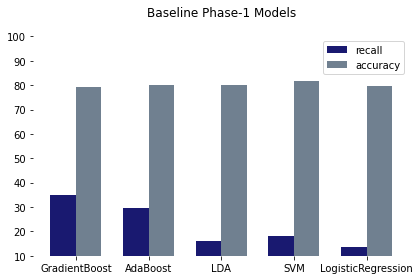

In [68]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['accuracy'] = [79.1,80.01,80.01,81.59,79.6]
df['recall'] = [35.13,29.7,16.21,18.2,13.5]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall',color = 'midnightblue')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy',color = 'slategrey')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Baseline Phase-1 Models',pad = 20)
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(10,100)
fig.tight_layout()
plt.box(False)
plt.show()

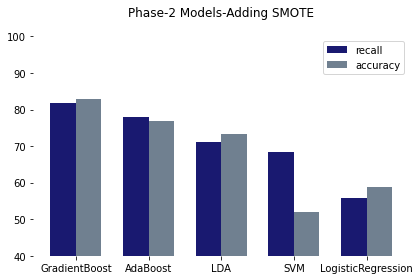

In [69]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['recall'] = [81.8,77.9,71.1,68.4,55.7]
df['accuracy'] = [82.8,76.8,73.3,52.06,58.7]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall',color = 'midnightblue')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy',color = 'slategrey')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Phase-2 Models-Adding SMOTE',pad = 20)
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(40,100)
fig.tight_layout()
plt.box(False)
plt.show()

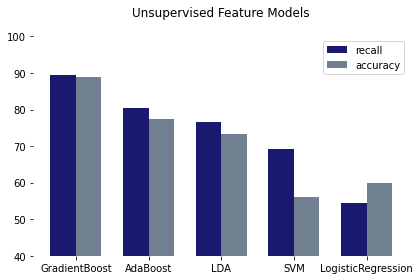

In [70]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['recall'] = [89.4,80.5,76.5,69.23,54.4]
df['accuracy'] = [88.8,77.4,73.3,56.19,60]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall',color = 'midnightblue')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy',color = 'slategrey')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Unsupervised Feature Models',pad = 20)
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(40,100)
fig.tight_layout()
plt.box(False)

plt.show()

In [71]:
X_test.shape, X_train.shape

((315, 15), (1259, 15))

In [83]:
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [87]:
probas = model.predict_proba(X_train)[:,1]
predicted = model.predict(X_train)
actual = y_train.values

X_train['probas'] = probas
X_train['predicted'] = predicted 
X_train['actual'] =  actual 

In [89]:
X_train.to_excel('result.xlsx',index = False)

In [109]:
f = pd.DataFrame()
f['age'] = X_train.age
f['age_group'] = pd.qcut(f.age,8)
f['proba'] = X_train['probas']
f['predicted'] = X_train['predicted']
f['actual'] = X_train['actual'] 
dfnew = f.sort_values(by = ['age'])
dfnew.head()

,age,age_group,proba,predicted,actual
1090,-0.923077,"(-0.924, -0.692]",0.618079,1,1
450,-0.923077,"(-0.924, -0.692]",0.132570,0,0
804,-0.923077,"(-0.924, -0.692]",0.857499,1,1
877,-0.923077,"(-0.924, -0.692]",0.491518,0,0
172,-0.923077,"(-0.924, -0.692]",0.306776,0,1


In [135]:
groups = dfnew.age_group.unique()
ratios = []
for i in dfnew.age_group.unique():
    df = dfnew.groupby(by= 'age_group').get_group(i)
    ratios.append((df['predicted'].sum()/len(df['actual']))*100)

<BarContainer object of 8 artists>

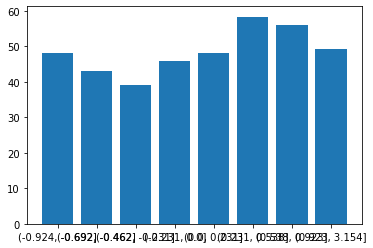

In [140]:
plt.bar(height = ratios,x = [str(i) for i in groups.categories])

In [155]:
[float(i).split(',')[0][1::] for i in groups.categories]

-0.924

In [154]:
float('(-0.924, -0.692]'.split(',')[1][::-1][1::][::-1])

-0.692